This notebook will explain how to make smooth polynomial coupling map models 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

import PLred.mapmodel as mm

In [3]:
couplingmap_data = '/home/first/yjkim/PLred/PLred/visPLred/examples/example_couplingmap/betcmi_20240917_couplingmap.fits'
wavs = '/home/first/yjkim/PLred/visPLred/examples/example_extract_spec/model/model_wavmap.npy'

data = fits.open(couplingmap_data)

frames0 = data[0].data
header = data[0].header
numframes = data[1].data
var = data[3].data
normvar = data[4].data

pos_mas = np.linspace(header['XMIN'], header['XMAX'], header['MAP_N'])

smooth_spectrum = False

if smooth_spectrum:

    from scipy.ndimage import gaussian_filter

    frames = np.zeros_like(frames0)
    for ix in range(len(pos_mas)):
        for iy in range(len(pos_mas)):
            for fibind in range(38):
                frames0[ix,iy,fibind] = gaussian_filter(frames0[ix,iy,fibind], sigma=1)




normalized = frames0 / np.nansum(frames0, axis=(0,1))[None,None,:,:]

n = len(pos_mas)

Text(0, 0.5, 'y (mas)')

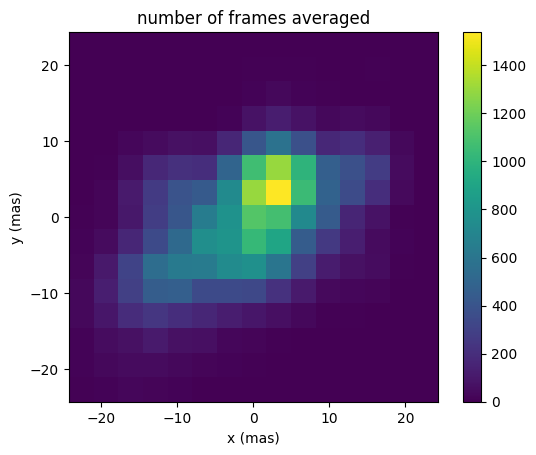

In [9]:
plt.imshow(numframes, extent = (pos_mas[0], pos_mas[-1],
                                pos_mas[0], pos_mas[-1]), origin='upper')
plt.colorbar()
plt.title('number of frames averaged')
plt.xlabel('x (mas)')
plt.ylabel('y (mas)')

In [11]:
mapmodel = mm.CouplingMapModel(mapdata = couplingmap_data)


loading mapdata
masking data with less than 5 frames


In [12]:
wav_fitrange = np.r_[0:100, 120:200]
wav_reconrange = np.r_[0:200]
all_map_inputs, all_modeled_recons, all_modeled_coeffs, model_chi2 = \
    mapmodel.make_polynomial_model('betcmi_20240917_polymodel', wav_fitrange, wav_reconrange)

100%|██████████| 38/38 [00:08<00:00,  4.64it/s]

betcmi_20240917_polymodel.fits saved


(0.0, 0.02)

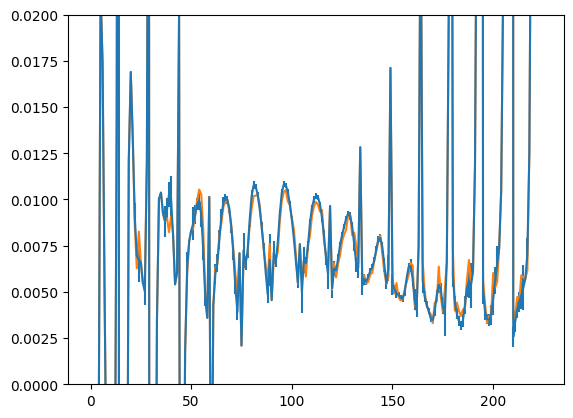

In [14]:
specind = 71
fibind = 33

plt.errorbar(np.arange(225), all_modeled_recons[:,:,fibind,specind].ravel(),np.sqrt(mapmodel.datanormvar[:,:,fibind,specind].ravel()))
plt.plot(all_map_inputs[:,:,fibind,specind].ravel())
# plt.xlim([0,50])
plt.ylim([0,0.02])

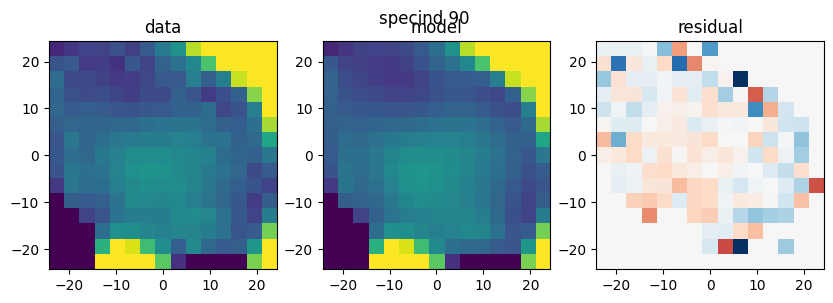

In [20]:
fig, axs = plt.subplots(ncols=3, figsize=(10,3))

fibind = 33

def animate(specind):
    for ax in axs: ax.clear()
    axs[0].imshow(all_map_inputs[:,:,fibind,specind],vmin=0,vmax=0.02, origin='lower',
                  extent = (min(pos_mas), max(pos_mas), min(pos_mas), max(pos_mas)))
    axs[1].imshow(all_modeled_recons[:,:,fibind,specind],vmin=0,vmax=0.02, origin='lower',
                  extent = (min(pos_mas), max(pos_mas), min(pos_mas), max(pos_mas)))
    axs[2].imshow(all_map_inputs[:,:,fibind,specind] - all_modeled_recons[:,:,fibind,specind],vmin=-0.002,vmax=0.002,cmap='RdBu',
                  origin='lower',
                  extent = (min(pos_mas), max(pos_mas), min(pos_mas), max(pos_mas)))
    # axs[3].imshow((all_map_input[specind]-modeled_recon[specind]),vmin=-0.001,vmax=0.001,cmap='RdBu')
    fig.suptitle('specind %d' % wav_reconrange[specind])

    axs[0].set_title('data')
    axs[1].set_title('model')
    axs[2].set_title('residual')

anim = FuncAnimation(fig, animate,np.arange(90,120), interval = 100)
HTML(anim.to_jshtml())